## Assignment 2: Network Safety


#### CSC 180  Intelligent Systems (Spring 2020)

#### Ace English

# Helpful Functions for Tensorflow

In [19]:
from collections.abc import Sequence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import svm, datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import random


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    
    
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Visualizing data


## Read data

In [10]:
#define datatypes for readability later
datatype={}

datatype["duration"] = "continuous"
datatype["protocol_type"] = "symbolic"
datatype["service"] = "symbolic"
datatype["flag"] = "symbolic"
datatype["src_bytes"] = "continuous"
datatype["dst_bytes"] = "continuous"
datatype["land"] = "symbolic"
datatype["wrong_fragment"] = "continuous"
datatype["urgent"] = "continuous"
datatype["hot"] = "continuous"
datatype["num_failed_logins"] = "continuous"
datatype["logged_in"] = "symbolic"
datatype["num_compromised"] = "continuous"
datatype["root_shell"] = "continuous"
datatype["su_attempted"] = "continuous"
datatype["num_root"] = "continuous"
datatype["num_file_creations"] = "continuous"
datatype["num_shells"] = "continuous"
datatype["num_access_files"] = "continuous"
datatype["num_outbound_cmds"] = "continuous"
datatype["is_host_login"] = "symbolic"
datatype["is_guest_login"] = "symbolic"
datatype["count"] = "continuous"
datatype["srv_count"] = "continuous"
datatype["serror_rate"] = "continuous"
datatype["srv_serror_rate"] = "continuous"
datatype["rerror_rate"] = "continuous"
datatype["srv_rerror_rate"] = "continuous"
datatype["same_srv_rate"] = "continuous"
datatype["diff_srv_rate"] = "continuous"
datatype["srv_diff_host_rate"] = "continuous"
datatype["dst_host_count"] = "continuous"
datatype["dst_host_srv_count"] = "continuous"
datatype["dst_host_same_srv_rate"] = "continuous"
datatype["dst_host_diff_srv_rate"] = "continuous"
datatype["dst_host_same_src_port_rate"] = "continuous"
datatype["dst_host_srv_diff_host_rate"] = "continuous"
datatype["dst_host_serror_rate"] = "continuous"
datatype["dst_host_srv_serror_rate"] = "continuous"
datatype["dst_host_rerror_rate"] = "continuous"
datatype["dst_host_srv_rerror_rate"] = "continuous"
datatype["outcome"] = "symbolic"


df = pd.read_csv("network_intrusion_data.csv")

#assign columns
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']

df

duration protocol_type service flag  src_bytes  dst_bytes  land  \
0              0           tcp    http   SF        239        486     0   
1              0           tcp    http   SF        235       1337     0   
2              0           tcp    http   SF        219       1337     0   
3              0           tcp    http   SF        217       2032     0   
4              0           tcp    http   SF        217       2032     0   
...          ...           ...     ...  ...        ...        ...   ...   
494015         0           tcp    http   SF        310       1881     0   
494016         0           tcp    http   SF        282       2286     0   
494017         0           tcp    http   SF        203       1200     0   
494018         0           tcp    http   SF        291       1200     0   
494019         0           tcp    http   SF        219       1234     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                    0       0    0  ...                  19   
1                    0       0    0  ...                  29   
2                    0       0    0  ...                  39   
3                    0       0    0  ...                  49   
4                    0       0    0  ...                  59   
...                ...     ...  ...  ...                 ...   
494015               0       0    0  ...                 255   
494016               0       0    0  ...                 255   
494017               0       0    0  ...                 255   
494018               0       0    0  ...                 255   
494019               0       0    0  ...                 255   

        dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                          1.0                     0.0   
1                          1.0                     0.0   
2                          1.0                     0.0   
3                          1.0                     0.0   
4                          1.0                     0.0   
...                        ...                     ...   
494015                     1.0                     0.0   
494016                     1.0                     0.0   
494017                     1.0                     0.0   
494018                     1.0                     0.0   
494019                     1.0                     0.0   

        dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                              0.05                         0.00   
1                              0.03                         0.00   
2                              0.03                         0.00   
3                              0.02                         0.00   
4                              0.02                         0.00   
...                             ...                          ...   
494015                         0.01                         0.05   
494016                         0.17                         0.05   
494017                         0.06                         0.05   
494018                         0.04                         0.05   
494019                         0.17                         0.05   

        dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                       0.00                      0.00                   0.0   
1                       0.00                      0.00                   0.0   
2                       0.00                      0.00                   0.0   
3                       0.00                      0.00                   0.0   
4                       0.00                      0.00                   0.0   
...                      ...                       ...                   ...   
494015                  0.00                      0.01                   0.0   
494016                  0.00                      0.01                   0.0   
494017                  0.06                      0.01                   0.0   
494018                  

# Data Examination
Now we clean the data. Part of this process is checking for redundant records and records with missing values. Like normal, we will encode categorical data and normalizing numerical data.

First we want to search for duplicates and remove them. Then we want to see what kind of sample sizes we can work with which each of these, so instead of just returning each list I want to produce a count.


In [11]:
df_dupes=df[df.duplicated()]
print ("Removing ",df_dupes.shape[0]," duplicate entries...")
df_unique=df.drop_duplicates()

#view all values
for (colName, colData) in df_unique.iteritems():
    valueCount=colData.drop_duplicates()
    print(colName, "-",valueCount.size, valueCount.values)

#check values count
i=0
for (colName, colData) in df_unique.iteritems():
    value_counts=colData.value_counts();
    print("Name: ",colName," Type: ",list(datatype)[i], "Size:", value_counts.size)
    print(value_counts.sort_values(ascending=False))
    print()
    i=i+1

Removing  348435  duplicate entries...
duration - 2495 [   0    1   79 ... 2695 2751  120]
protocol_type - 3 ['tcp' 'udp' 'icmp']
service - 66 ['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']
flag - 11 ['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']
src_bytes - 3300 [239 235 219 ... 500 484 475]
dst_bytes - 10725 [  486  1337  2032 ... 34557 10592 13828]
land - 2 [0 1]
wrong_fragment - 3 [0 1 3]
urgent - 4 [0 2 1 3]
hot - 22 [ 0  1  3 19  6  4 30 

Name:  flag  Type:  flag Size: 11
SF        87458
S0        42278
REJ       14712
RSTO        569
RSTR        425
S1           57
SH           34
S2           24
RSTOS0       11
S3           10
OTH           7
Name: flag, dtype: int64

Name:  src_bytes  Type:  src_bytes Size: 3300
0        57872
147       1962
105       1467
146       1454
42         941
         ...  
13545        1
5512         1
11370        1
92994        1
2047         1
Name: src_bytes, Length: 3300, dtype: int64

Name:  dst_bytes  Type:  dst_bytes Size: 10725
0        67663
105       3199
8314       899
330        854
329        804
         ...  
3210         1
4635         1
6682         1
11132        1
16584        1
Name: dst_bytes, Length: 10725, dtype: int64

Name:  land  Type:  land Size: 2
0    145565
1        20
Name: land, dtype: int64

Name:  wrong_fragment  Type:  wrong_fragment Size: 3
0    144464
3       910
1       211
Name: wrong_fragment, dtype: int64

Name:  urgent  Type:  urgent Size: 4
0    

0.00    125255
1.00     13142
0.01      1849
0.02       625
0.04       377
         ...  
0.21         6
0.32         5
0.28         4
0.22         4
0.26         4
Name: dst_host_srv_rerror_rate, Length: 101, dtype: int64

Name:  outcome  Type:  outcome Size: 23
normal.             87831
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: outcome, dtype: int64



All this data looks valid.

`num_outbound_cmds` and `is_host_login` both have only 1 entry type, so they can be dropped.

We also see that several of the fields have a huge disparity in volume. `urgent` is almost entirely 0. Several other fields have a huge majority of one field with other fields being rare. However, several of these may be crucial for finding attacks.


`wrong_fragment`, `num_failed_logins`, `num_compromised`, `hot`, `root_shell`, `su_attempted`, `num_root`, `num_file_creations`, `num_shells`, `is_guest_login`, `num_access_files`

## Separating attacks from normal
We will filter off the attacks from the normal dataspace to see if their representation makes more sense when looking at non-normal data.

In [12]:
#drop worthless data
df_unique=df_unique.drop(['is_host_login','num_outbound_cmds'], axis=1)

#remove rows with missing data
df_unique=df_unique.dropna()

outliers=['outcome','land','wrong_fragment', 'num_failed_logins', 'num_compromised', 'hot', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'is_guest_login', 'num_access_files']
df_normals=df_unique[df_unique['outcome']=='normal.']
df_attacks=df_unique.drop(df_normals.index)

i=0
for (colName, colData) in df_attacks.iteritems():
    if(colName in outliers):
        value_counts=colData.value_counts();
        print("Name: ",colName," Type: ",list(datatype)[i], "Size:", value_counts.size)
        print(value_counts.sort_values(ascending=False))
        print()
    i=i+1

Name:  land  Type:  land Size: 2
0    57735
1       19
Name: land, dtype: int64

Name:  wrong_fragment  Type:  wrong_fragment Size: 3
0    56633
3      910
1      211
Name: wrong_fragment, dtype: int64

Name:  hot  Type:  hot Size: 14
0     56339
2       917
28      274
1       133
3        34
5        16
4        15
20        9
6         8
19        5
7         1
10        1
15        1
18        1
Name: hot, dtype: int64

Name:  num_failed_logins  Type:  num_failed_logins Size: 3
0    57701
1       52
5        1
Name: num_failed_logins, dtype: int64

Name:  num_compromised  Type:  num_compromised Size: 10
0     56832
1       901
2         8
4         7
3         1
5         1
6         1
38        1
16        1
22        1
Name: num_compromised, dtype: int64

Name:  root_shell  Type:  root_shell Size: 2
0    57722
1       32
Name: root_shell, dtype: int64

Name:  su_attempted  Type:  su_attempted Size: 2
0    57753
1        1
Name: su_attempted, dtype: int64

Name:  num_root  Type:  

Surprisingly a lot of these values are still disproportionate even among errors only. Many of them will get dropped later.

`num_failed_logins`,`root_shell`,`su_attempted`,`num_root`, `num_file_creations`,`num_shells`, `num_access_files` seem irrelevent and have very little data to go off of.

## Data prep
Next I'm going to format the arrays in a useful way. To encode output as safe/unsafe, I will add another layer "attack" and drop the layer "outcome" (I supsect the neural network will rely too heavily on it if I leave it in.)

I am also going to apply **downsampling** here so that the quantity of good connections more closely matches the volume of attacks.

### Normalization and one-hot encoding

For `outcome` we don't care what the error code is (just that it is not normal). After normalization columns may get dropped because the values are not significant enough to be nonzero. This is fine.

In [38]:
drop_columns=['urgent','land','num_failed_logins', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
              'num_shells', 'num_access_files']
#Model using fewer of the good samples - same number as most common error
df_downsampled=df_normals.sample(51820).append(df_attacks)
#model dropping rows that might be irrelevent
df_slim=df_unique.drop(drop_columns,axis=1)
#model dropping irrelevent rows AND using downsampling
df_slim_downsampled=df_downsampled.drop(drop_columns,axis=1)



#map for encoding
def make_binary(string):
    if(string=="normal."):
        return 0
    else:
        return 1

#encode y
y=df_slim_downsampled["outcome"].map(make_binary)
#y_test_model=df_slim["outcome"].map(make_binary)

#get arrays for training
df_data=df_slim_downsampled.drop(["outcome"], axis=1)


#prep for model
for (name,column) in df_data.iteritems():
    if(datatype[name]=='continuous'):
        encode_numeric_zscore(df_data, name)
    else:
        encode_text_dummy(df_data,name)

#get arrays for testing
#df_test=df_slim.drop(["outcome"], axis=1)
#for (name,column) in df_test.iteritems():
#    if(datatype[name]=='continuous'):
#        encode_numeric_zscore(df_test, name)
#    else:
#        encode_text_dummy(df_test,name)
        

 # Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df_data, y, test_size=0.25, random_state=42) 


After data prep some colums may now have no different values in them, in essence the rare values to a general majority may have been entirely dropped so the one-hot encoded label is now empty.

## Random testing
> Debugging by hand is like trying to find tiny holes in a dartboard covered in cloth...and you only have 5 darts.


To compare models, we are comparing the **accuracy, recall, precision** and **F1** score.

In [45]:
def test_model(y_test, pred):
    cm = confusion_matrix(y_test, pred)
    print(cm)


    labels=["good","attack"]
    plt.figure()
    plot_confusion_matrix(cm, labels)
    plt.show()

    print(classification_report(y_test, pred))
    plot_roc(pred,y_test)

# Model Training
For each type of model we will test different variable weights.
## KNN
Tweak number of **neighbors** for comparison.
## Fully connected Neural Network
- Activation: **relu**, **sigmoid**, **tanh**
- **Layer count**
- **Neuron count**
- Optimizer: **Adam**, **SGC**

## Convuluted Neural Network
All of the same from Neural Network plus **kernal number** and **kernal size**

3 neighbors
[[13007    26]
 [   28 14333]]


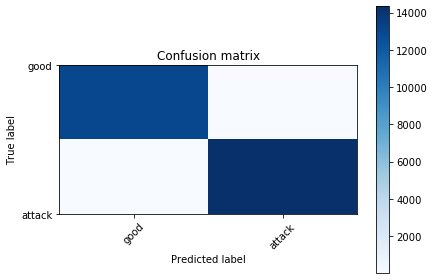

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13033
           1       1.00      1.00      1.00     14361

    accuracy                           1.00     27394
   macro avg       1.00      1.00      1.00     27394
weighted avg       1.00      1.00      1.00     27394



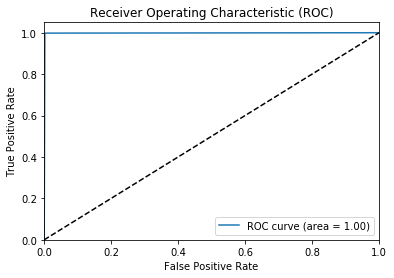

5 neighbors
[[13007    26]
 [   31 14330]]


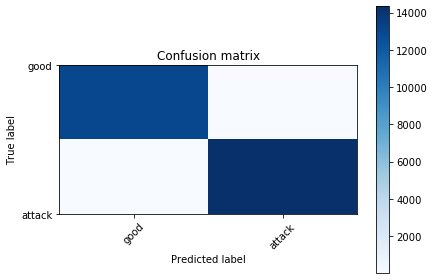

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13033
           1       1.00      1.00      1.00     14361

    accuracy                           1.00     27394
   macro avg       1.00      1.00      1.00     27394
weighted avg       1.00      1.00      1.00     27394



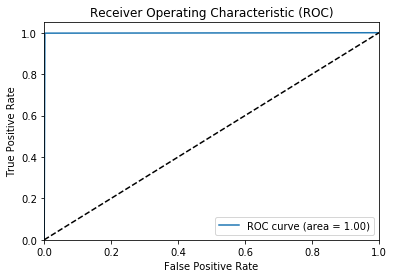

7 neighbors
[[13008    25]
 [   34 14327]]


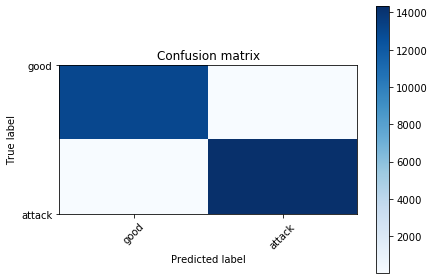

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13033
           1       1.00      1.00      1.00     14361

    accuracy                           1.00     27394
   macro avg       1.00      1.00      1.00     27394
weighted avg       1.00      1.00      1.00     27394



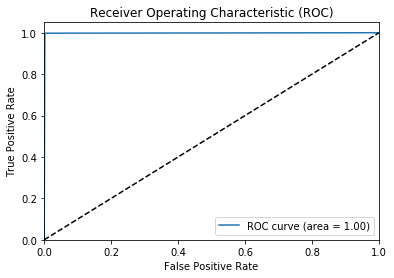

In [49]:
def test_knn(neighbors,x_train,y_train,x_test,y_test):
    print(neighbors,"neighbors")
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(x_train,y_train)
    pred = knn.predict(x_test)
    test_model(y_test, pred)


    

test_knn(1,x_train,y_train,x_test,y_test)
test_knn(3,x_train,y_train,x_test,y_test)
test_knn(5,x_train,y_train,x_test,y_test)
test_knn(7,x_train,y_train,x_test,y_test)